In [3]:
# ============================================================================
#                            IMPORTAÇÕES
# ============================================================================
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

# Ignorando os avisos de possíveis alertas não críticos
import warnings
warnings.filterwarnings("ignore")

# Pacotes de modelagem e métricas
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, roc_auc_score
from sklearn.preprocessing import MinMaxScaler

# Modelos
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Oversampling
from imblearn.over_sampling import SMOTE

# Modelos de sobrevivência
from lifelines import CoxPHFitter, KaplanMeierFitter

# Salvando modelo
import joblib

# SHAP para interpretabilidade
import shap


In [4]:
# ============================================================================
#                    FUNÇÕES AUXILIARES DE VISUALIZAÇÃO E MÉTRICAS
# ============================================================================
def plot_distribution_by_attrition(df, feature, bins="auto"):
    """
    Plota a distribuição de uma feature separando por 'Attrition'.
    """
    plt.figure(figsize=(8,6))
    sns.histplot(data=df, x=feature, hue='Attrition', kde=True, bins=bins)
    plt.title(f"Distribuição de {feature} por Attrition")
    plt.show()


def plot_boxplot_by_attrition(df, feature):
    """
    Plota boxplot de uma feature separando por 'Attrition'.
    """
    plt.figure(figsize=(8,6))
    sns.boxplot(data=df, x='Attrition', y=feature)
    plt.title(f"{feature} vs Attrition")
    plt.show()


def evaluate_classification_model(model, X_train, y_train, X_test, y_test):
    """
    Treina e avalia um modelo de classificação,
    retornando métricas de performance e exibindo relatórios.
    """

    # Previsão no conjunto de treino
    y_pred_train = model.predict(X_train)
    y_pred_prob_train = model.predict_proba(X_train)[:,1]
    auc_train = roc_auc_score(y_train, y_pred_prob_train)

    # Previsão no conjunto de teste
    y_pred_test = model.predict(X_test)
    y_pred_prob_test = model.predict_proba(X_test)[:,1]
    auc_test = roc_auc_score(y_test, y_pred_prob_test)

    print("=== Métricas Treinamento ===")
    print(f"AUC-ROC Treino : {auc_train:.2f}")
    print(classification_report(y_train, y_pred_train))

    print("=== Métricas Teste ===")
    print(f"AUC-ROC Teste  : {auc_test:.2f}")
    print(classification_report(y_test, y_pred_test))

    # Matriz de confusão (Teste)
    print("Matriz de Confusão (Teste):")
    print(confusion_matrix(y_test, y_pred_test))

    # Plotando curva ROC Treino e Teste
    fpr_train, tpr_train, _ = roc_curve(y_train, y_pred_prob_train)
    fpr_test, tpr_test, _   = roc_curve(y_test,  y_pred_prob_test)

    plt.figure(figsize=(10,6))
    plt.plot(fpr_train, tpr_train, label='Treino (AUC=%.2f)' % auc_train, color='blue')
    plt.plot(fpr_test,  tpr_test,  label='Teste  (AUC=%.2f)' % auc_test,  color='red')
    plt.plot([0,1], [0,1], 'k--')
    plt.title('Curvas ROC')
    plt.xlabel('Falso Positivo')
    plt.ylabel('Verdadeiro Positivo')
    plt.legend(loc='lower right')
    plt.show()

    return {
        "auc_train": auc_train,
        "auc_test": auc_test
    }


def classify_risk(prob, low_threshold=0.10, medium_threshold=0.40):
    """
    Classifica o risco (Baixo, Moderado, Alto) a partir de probabilidades.
    Parâmetros customizáveis: (low_threshold, medium_threshold).
    """
    if prob < low_threshold:
        return "Baixo"
    elif prob < medium_threshold:
        return "Moderado"
    else:
        return "Alto"


def create_risk_df(model, X, y, low_threshold=0.10, medium_threshold=0.40):
    """
    Retorna um DataFrame com a probabilidade predita, a classificação de risco
    e o valor real de y (Attrition) para análise.
    """
    pred_prob = model.predict_proba(X)[:, 1]
    risk_df = X.copy()
    risk_df['Probabilidade'] = pred_prob
    risk_df['Risco'] = risk_df['Probabilidade'].apply(
        lambda x: classify_risk(x, low_threshold, medium_threshold)
    )
    risk_df['Attrition'] = y.values
    return risk_df


def plot_risk_distribution(risk_df):
    """
    Plota um countplot da coluna 'Risco' separando por 'Attrition'.
    """
    plt.figure(figsize=(10,6))
    sns.countplot(data=risk_df, x='Risco', hue='Attrition')
    plt.title('Distribuição de Risco vs. Attrition')
    plt.xlabel('Classificação de Risco')
    plt.ylabel('Quantidade')
    plt.legend(title='Attrition', labels=['Ficaram (0)', 'Saíram (1)'])
    plt.show()

# Paleta de cor para os gráficos
palette = {"Yes": "#c0392b", "No": "#3498db"}


In [5]:
# ============================================================================
#              CARREGAMENTO DOS DADOS E EXPLORAÇÃO INICIAL
# ============================================================================
# Configurando para mostrar todas as colunas
pd.set_option('display.max_columns', None)

# Lendo o dataset
data = pd.read_csv('../02. Datasets//hr_employee_attrition.csv')

# Primeira visão geral do dataframe
data.head()
data.info()

# Análise inicial das estatísticas descritivas
data.describe(include='int64')
data.describe(include='object')

# Verificando valores nulos em colunas
na_cols = data.isna().sum()
na_cols = na_cols[na_cols > 0]
if na_cols.empty:
    print("Não há valores nulos.")
else:
    print("Colunas com valores nulos:\n", na_cols)

# Verificando se existem linhas duplicas/idênticas
duplicados = data.duplicated().sum()
print(f"Total de linhas duplicadas: {duplicados}")

# Distribuição da variável target
print("\nAttrition - Contagem Absoluta:")
print(data['Attrition'].value_counts())
print("\nAttrition - Contagem Relativa:")
print(data['Attrition'].value_counts(normalize=True))


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

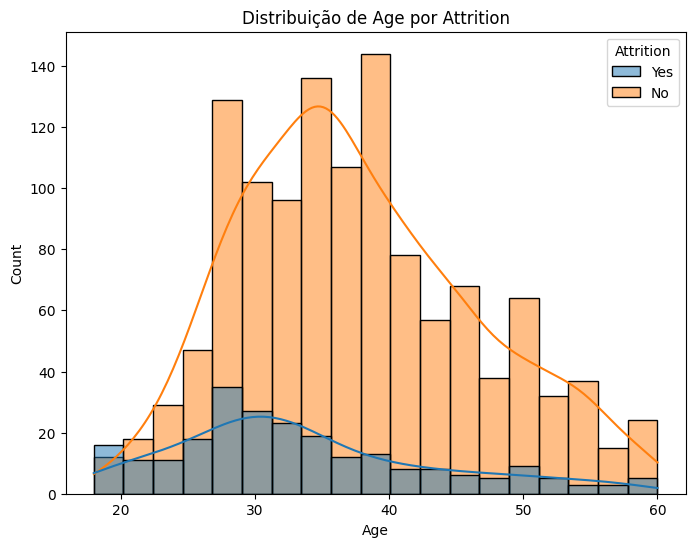

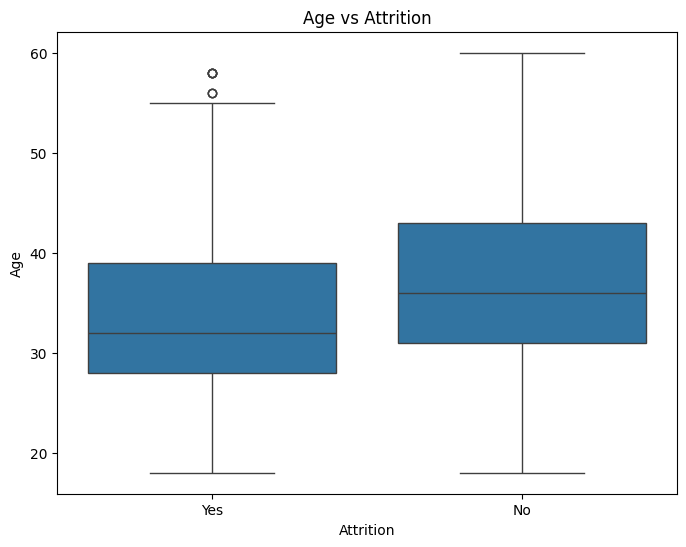

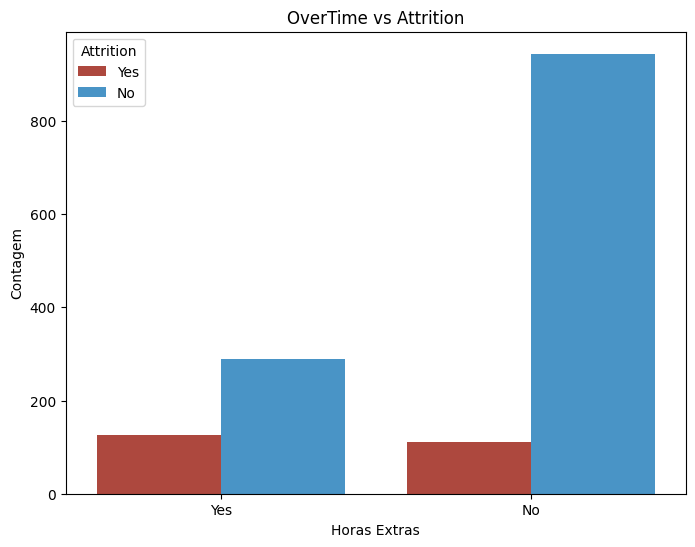

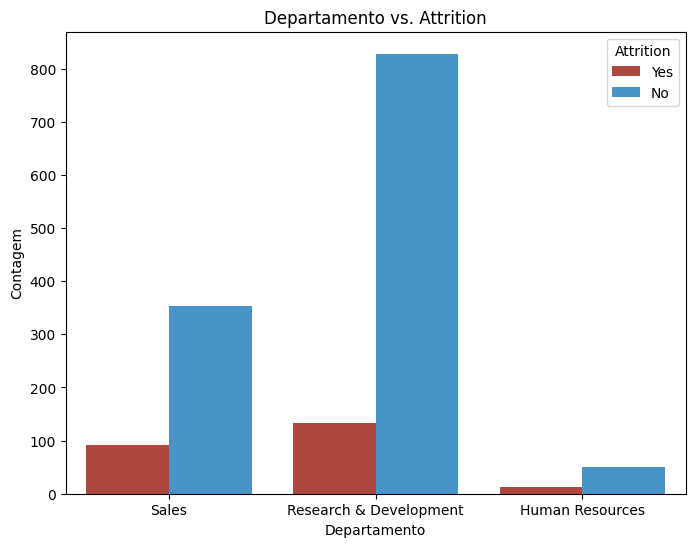

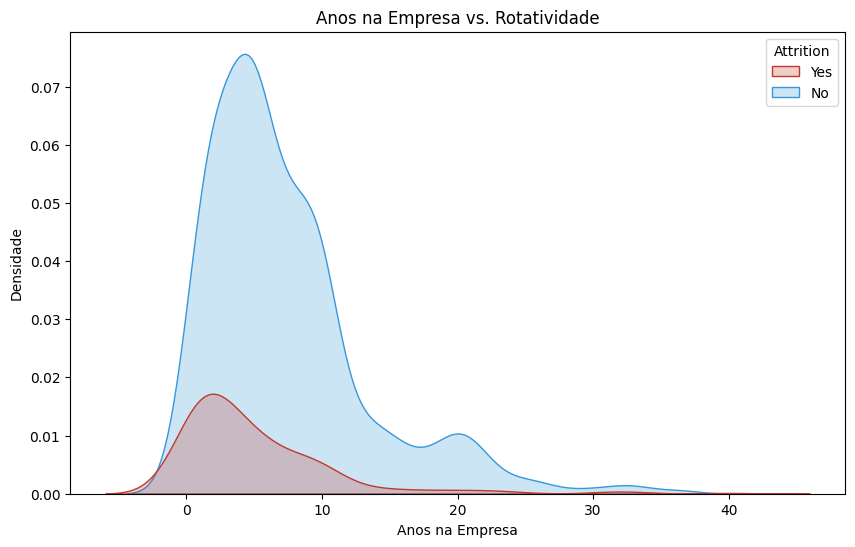

In [6]:
# ============================================================================
#                 ANÁLISE EXPLORATÓRIA DOS DADOS
# ============================================================================

# Como a Idade impacta na Attrition?
plot_distribution_by_attrition(data, 'Age')
plot_boxplot_by_attrition(data, 'Age')

# Análise de OverTime vs. Attrition
plt.figure(figsize=(8,6))
sns.countplot(x='OverTime', hue='Attrition', data=data, palette=palette)
plt.title('OverTime vs Attrition')
plt.xlabel('Horas Extras')
plt.ylabel('Contagem')
plt.legend(title='Attrition')
plt.show()

# Análise de Department vs. Attrition
plt.figure(figsize=(8,6))
sns.countplot(x='Department', hue='Attrition', data=data, palette=palette)
plt.title('Departamento vs. Attrition')
plt.xlabel('Departamento')
plt.ylabel('Contagem')
plt.legend(title='Attrition')
plt.show()

# Análise de YearsAtCompany vs. Attrition
plt.figure(figsize=(10,6))
sns.kdeplot(data=data, x='YearsAtCompany', hue='Attrition', shade=True, palette=palette)
plt.title('Anos na Empresa vs. Rotatividade')
plt.xlabel('Anos na Empresa')
plt.ylabel('Densidade')
plt.show()


In [7]:
# ============================================================================
#                 PROCESSAMENTO DE DADOS
# ============================================================================
data_prep = data.copy()

# Transformações manuais - simple encoding
data_prep['BusinessTravel'] = data_prep['BusinessTravel'].map({'Travel_Frequently':2, 'Travel_Rarely':1, 'Non-Travel':0})
data_prep['Gender'] = data_prep['Gender'].map({'Male':1, 'Female':0})
data_prep['OverTime'] = data_prep['OverTime'].map({'Yes':1, 'No':0})

# One-Hot Encoding
columns_to_dummy = ['Department', 'EducationField', 'JobRole', 'MaritalStatus']
data_prep = pd.get_dummies(data_prep, columns=columns_to_dummy, drop_first=True, dtype='int64')

# Criando variável target binária: Attrition_numerical
data_prep['Attrition_numerical'] = data['Attrition'].map({'Yes':1, 'No':0})

# Removendo colunas desnecessárias
# essas colunas não irão nos apoiar 
cols_to_delete = ['Over18', 'StandardHours', 'EmployeeNumber', 'EmployeeCount', 'Attrition']
data_prep.drop(cols_to_delete, axis=1, inplace=True)

data_prep.head()

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Department_Research & Development,Department_Sales,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Married,MaritalStatus_Single,Attrition_numerical
0,41,1,1102,1,2,2,0,94,3,2,4,5993,19479,8,1,11,3,1,0,8,0,1,6,4,0,5,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,1
1,49,2,279,8,1,3,1,61,2,2,2,5130,24907,1,0,23,4,4,1,10,3,3,10,7,1,7,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
2,37,1,1373,2,2,4,1,92,2,1,3,2090,2396,6,1,15,3,2,0,7,3,3,0,0,0,0,1,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,1
3,33,2,1392,3,4,4,0,56,3,1,3,2909,23159,1,1,11,3,3,0,8,3,3,8,7,3,0,1,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0
4,27,1,591,2,1,1,1,40,3,1,2,3468,16632,9,0,12,3,4,1,6,3,3,2,2,2,2,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0


In [8]:
# ============================================================================
#          SEPARAÇÃO EM TREINO/TESTE + BALANCEAMENTO (SMOTE)
# ============================================================================
X = data_prep.drop('Attrition_numerical', axis=1)
y = data_prep['Attrition_numerical']

# Aplicando SMOTE antes do split
smote = SMOTE(random_state=42)
X_smote, y_smote = smote.fit_resample(X, y)

# Split em Treino e Teste
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote,
                                                    test_size=0.20,
                                                    random_state=42,
                                                    stratify=y_smote)

print("Distribuição após SMOTE:")
print(pd.Series(y_smote).value_counts())

Distribuição após SMOTE:
Attrition_numerical
1    1233
0    1233
Name: count, dtype: int64


=== DECISION TREE ===
=== Métricas Treinamento ===
AUC-ROC Treino : 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       986

    accuracy                           1.00      1972
   macro avg       1.00      1.00      1.00      1972
weighted avg       1.00      1.00      1.00      1972

=== Métricas Teste ===
AUC-ROC Teste  : 0.83
              precision    recall  f1-score   support

           0       0.85      0.79      0.82       247
           1       0.80      0.87      0.83       247

    accuracy                           0.83       494
   macro avg       0.83      0.83      0.83       494
weighted avg       0.83      0.83      0.83       494

Matriz de Confusão (Teste):
[[194  53]
 [ 33 214]]


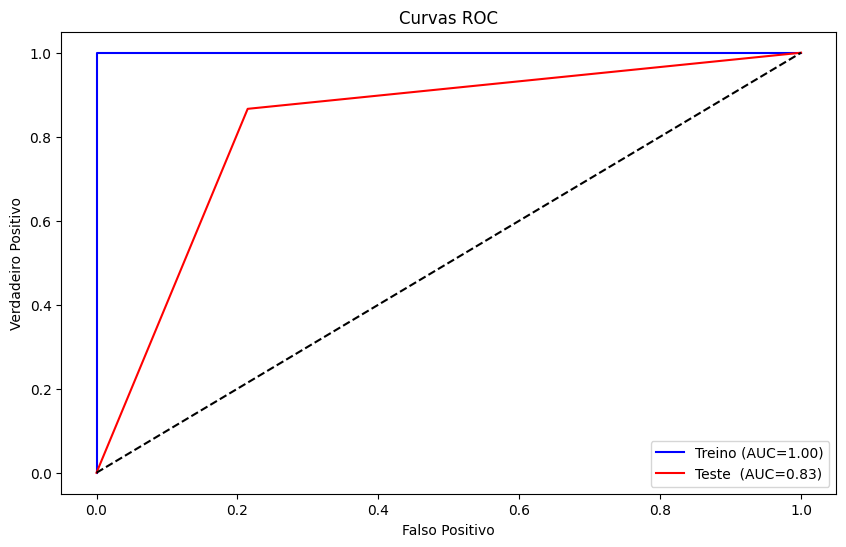


=== RANDOM FOREST ===
=== Métricas Treinamento ===
AUC-ROC Treino : 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       986

    accuracy                           1.00      1972
   macro avg       1.00      1.00      1.00      1972
weighted avg       1.00      1.00      1.00      1972

=== Métricas Teste ===
AUC-ROC Teste  : 0.97
              precision    recall  f1-score   support

           0       0.91      0.94      0.92       247
           1       0.94      0.91      0.92       247

    accuracy                           0.92       494
   macro avg       0.92      0.92      0.92       494
weighted avg       0.92      0.92      0.92       494

Matriz de Confusão (Teste):
[[232  15]
 [ 23 224]]


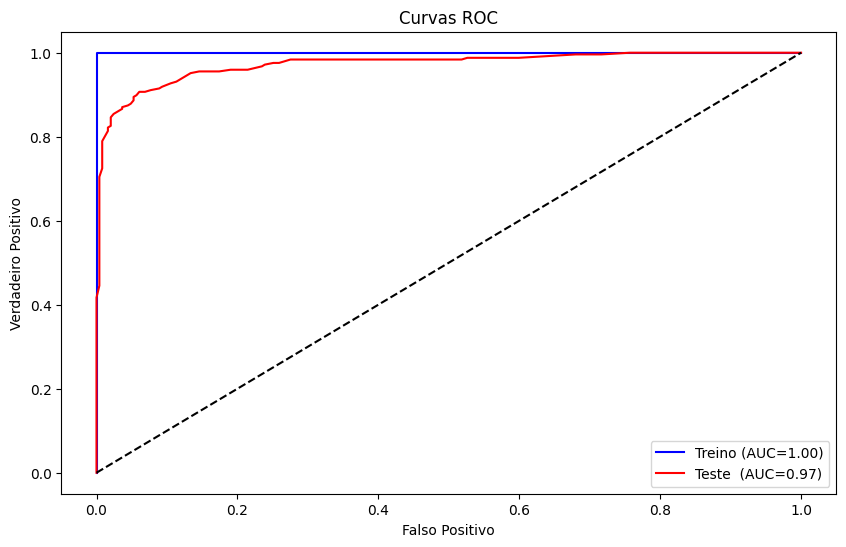

Validação Cruzada (Accuracy) - 5 Folds: 0.91


In [9]:
# ============================================================================
# MODELAGEM 1: Decision Tree e RandomForest
# ============================================================================

# ---------------------------
# DECISION TREE
# ---------------------------
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)

print("=== DECISION TREE ===")
_ = evaluate_classification_model(dtc, X_train, y_train, X_test, y_test)

# ---------------------------
# RANDOM FOREST
# ---------------------------

rfc = RandomForestClassifier(random_state=42)
rfc.fit(X_train, y_train)

print("\n=== RANDOM FOREST ===")
_ = evaluate_classification_model(rfc, X_train, y_train, X_test, y_test)

# Validação Cruzada (RandomForest)
cv_scores = cross_val_score(rfc, X_smote, y_smote, cv=5, scoring='accuracy')
print(f"Validação Cruzada (Accuracy) - 5 Folds: {cv_scores.mean():.2f}")

# ============================================================================
#                        ORDEM DAS FEATURES
# ============================================================================

column_order = X_train.columns.tolist()
with open("../03. Outputs/features_order.txt", "w") as f:
    for col in column_order:
        f.write(col + "\n")


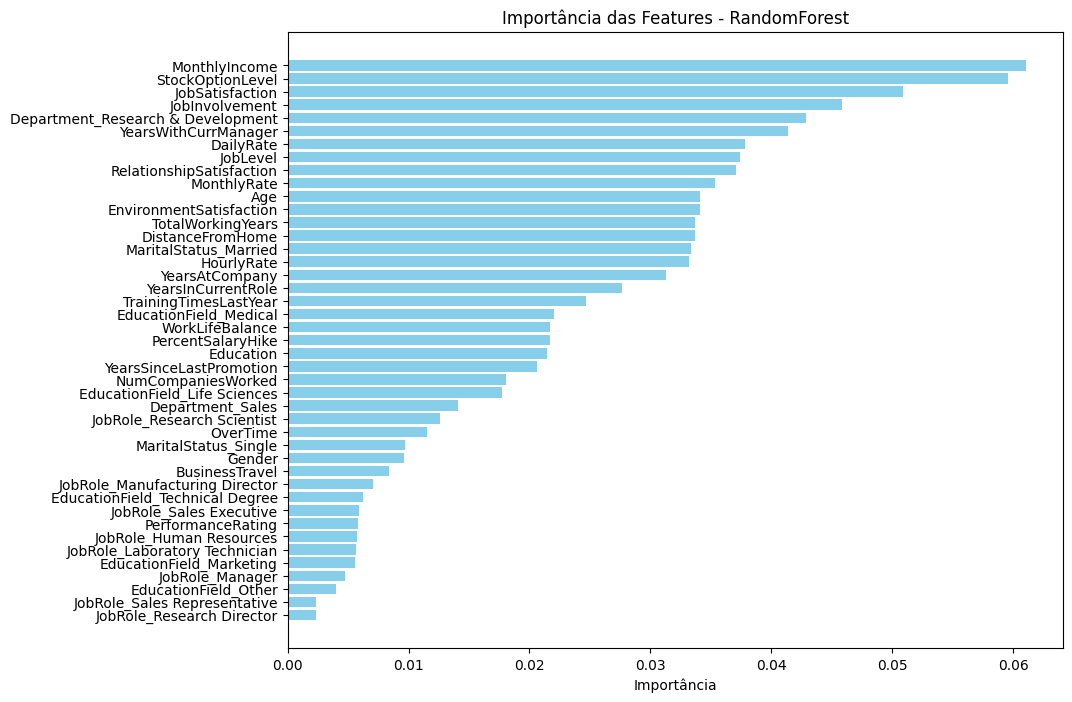

,Feature,Importance
11,MonthlyIncome,0.061037
18,StockOptionLevel,0.059607
10,JobSatisfaction,0.050912
8,JobInvolvement,0.045879
26,Department_Research & Development,0.042831
25,YearsWithCurrManager,0.041374
2,DailyRate,0.037817
9,JobLevel,0.037376
17,RelationshipSatisfaction,0.037088
12,MonthlyRate,0.035362


In [10]:
# ============================================================================
#           ANÁLISE DE IMPORTÂNCIA
# ============================================================================
feature_importances = rfc.feature_importances_
features_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': feature_importances
}).sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10,8))
plt.barh(features_df['Feature'], features_df['Importance'], color='skyblue')
plt.xlabel('Importância')
plt.title('Importância das Features - RandomForest')
plt.gca().invert_yaxis()
plt.show()

features_df.head(10)


In [11]:
# ============================================================================
#          ANÁLISE DE SOBREVIVÊNCIA: COX PROPORTIONAL HAZARDS
# ============================================================================
# Principais pontos:
#   - coef = indica se a variável impacta positiva ou negativamente no Attrition
#   - exp(coef) = hazard ratio para explicar se aumenta ou reduz o risco
#       - Ex.: 1.20 = risco 20% maior
#       - Ex.2: 0.80 = risco 20% menor
#   - p = coeficiente que sinaliza se é estatisticamente significativo (<0,05)

data_surv = data_prep.copy()

cph = CoxPHFitter()
cph.fit(data_surv,
        duration_col='YearsAtCompany',
        event_col='Attrition_numerical')
cph.print_summary()

# Índice de concordância do modelo
c_index = cph.concordance_index_
print(f"\nÍndice de Concordância (C-index) do Modelo Cox: {c_index:.2f}")


<lifelines.CoxPHFitter: fitted with 1470 total observations, 1233 right-censored observations>
             duration col = 'YearsAtCompany'
                event col = 'Attrition_numerical'
      baseline estimation = breslow
   number of observations = 1470
number of events observed = 237
   partial log-likelihood = -1156.32
         time fit was run = 2025-03-04 14:27:41 UTC

---
                                   coef exp(coef)  se(coef)  coef lower 95%  coef upper 95% exp(coef) lower 95% exp(coef) upper 95%
covariate                                                                                                                          
Age                               -0.02      0.98      0.01           -0.04            0.00                0.96                1.00
BusinessTravel                     0.61      1.85      0.13            0.36            0.87                1.43                2.39
DailyRate                         -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
DistanceFromHome                   0.03      1.03      0.01            0.01            0.04                1.01                1.04
Education                          0.00      1.00      0.07           -0.13            0.14                0.88                1.15
EnvironmentSatisfaction           -0.31      0.74      0.06           -0.43           -0.18                0.65                0.83
Gender                             0.40      1.50      0.15            0.12            0.69                1.13                1.99
HourlyRate                         0.00      1.00      0.00           -0.00            0.01                1.00                1.01
JobInvolvement                    -0.26      0.77      0.09           -0.44           -0.08                0.65                0.92
JobLevel                          -0.08      0.92      0.27           -0.61            0.44                0.54                1.55
JobSatisfaction                   -0.36      0.70      0.06           -0.49           -0.24                0.62                0.79
MonthlyIncome                     -0.00      1.00      0.00           -0.00            0.00                1.00                1.00
MonthlyRate                        0.00      1.00      0.00           -0.00            0.00                1.00                1.00
NumCompaniesWorked                 0.25      1.29      0.03            0.20            0.31                1.22                1.36
OverTime                           1.43      4.19      0.14            1.15            1.72                3.16                5.56
PercentSalaryHike                  0.01      1.01      0.03           -0.05            0.07                0.95                1.07
PerformanceRating                 -0.04      0.96      0.31           -0.65            0.57                0.52                1.78
RelationshipSatisfaction          -0.21      0.81      0.07           -0.33           -0.08                0.72                0.93
StockOptionLevel                  -0.20      0.82      0.13           -0.46            0.05                0.63                1.05
TotalWorkingYears                 -0.15      0.86      0.03           -0.21           -0.09                0.81                0.91
TrainingTimesLastYear             -0.21      0.81      0.06           -0.33           -0.09                0.72                0.91
WorkLifeBalance                   -0.16      0.85      0.09           -0.34            0.02                0.71                1.02
YearsInCurrentRole                -0.34      0.71      0.04           -0.41           -0.27                0.66                0.76
YearsSinceLastPromotion            0.06      1.06      0.03           -0.01            0.12                0.99                1.13
YearsWithCurrManager              -0.33      0.72      0.04           -0.40           -0.26                0.67                0.77
Department_Research & Development 15.32  4.51e+06  


Índice de Concordância (C-index) do Modelo Cox: 0.95


,YearsAtCompany,Attrition_numerical,Probabilidade,Risco
0,6,1,0.057140,Baixo
1,10,0,0.000142,Baixo
2,0,1,0.576912,Alto
3,8,0,0.004412,Baixo
4,2,0,0.129530,Moderado


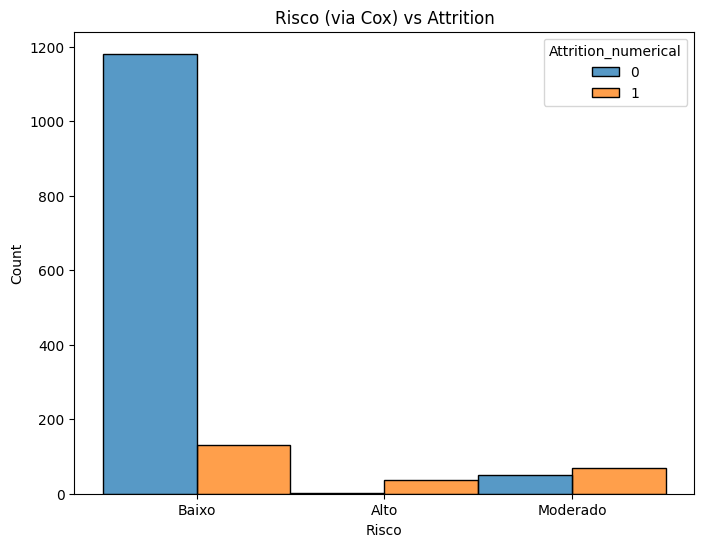

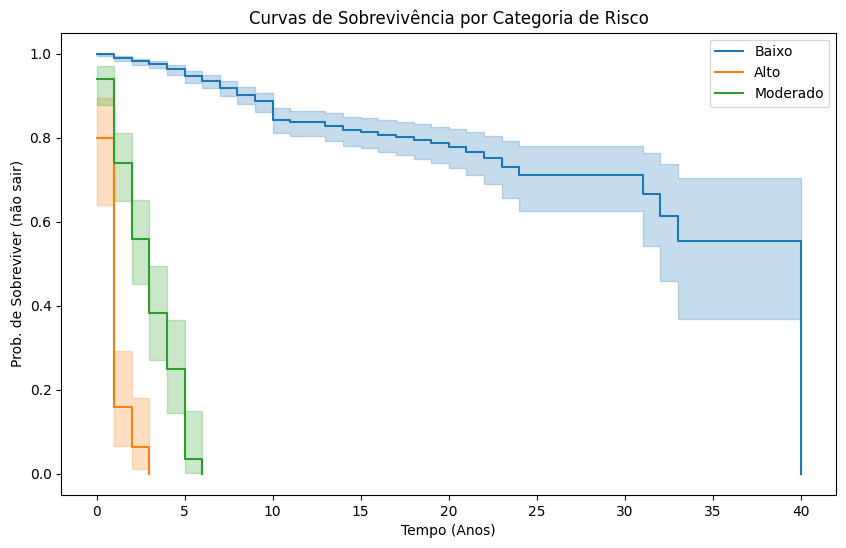

In [12]:
# ============================================================================
#                 CLASSIFICAÇÃO DE RISCO VIA COX
# ----------------------------------------------------------------------------
# Essa primeira abordagem analisa a probabilidade de sair em 1 ano, dando uma interpretação 
# do que acontece em um período de tempo específico: “Fulano tem 65% de chance de sair em até 1 ano."
# ============================================================================
# Vamos usar 1 ano como base neste projeto
survival_functions = cph.predict_survival_function(data_surv, times=[1])
prob_leave_in_1yr = 1 - survival_functions.iloc[0, :]

df_risco_cox = data_surv.copy()
df_risco_cox["Probabilidade"] = prob_leave_in_1yr.values

# Aplicando a função de Classificação de risco em cima da coluna da probabilidade produzida acima
df_risco_cox["Risco"] = df_risco_cox["Probabilidade"].apply(classify_risk)
display(df_risco_cox[['YearsAtCompany', 'Attrition_numerical', 'Probabilidade', 'Risco']].head())

# Plotando a distribuição dos riscos
plt.figure(figsize=(8,6))
sns.histplot(data=df_risco_cox, x='Risco', hue='Attrition_numerical', multiple='dodge')
plt.title("Risco (via Cox) vs Attrition")
plt.show()

# Vamos plotar também a curva de sobrevivência (KaplanMeier) 
# pela classificação de 'Risco' gerada
kmf = KaplanMeierFitter()

plt.figure(figsize=(10,6))
for categoria in df_risco_cox['Risco'].unique():
    mask = df_risco_cox['Risco'] == categoria
    kmf.fit(
        durations=df_risco_cox.loc[mask, 'YearsAtCompany'],
        event_observed=df_risco_cox.loc[mask, 'Attrition_numerical'],
        label=categoria
    )
    kmf.plot_survival_function()

plt.title('Curvas de Sobrevivência por Categoria de Risco')
plt.xlabel('Tempo (Anos)')
plt.ylabel('Prob. de Sobreviver (não sair)')
plt.legend()
plt.show()


In [ ]:
# ============================================================================
#         SCORE DE RISCO (HAZARD RATIOS DO COX)
# ----------------------------------------------------------------------------
# A segunda forma de calcular o risco é geral, isto é, não está fixada em um período de tempo específico.
# Para a gestão e para o RH, retorna uma espécie de 'ranking' global do risco de 'Fulano' sair
# ============================================================================
def score_classificator(score):
    """
    Transformando o score contínuo em faixas (Baixo, Moderado, Elevado).
    Ajuste os limites conforme seu problema.
    """
    if score < 0.2:
        return 'Baixo'
    elif score < 0.5:
        return 'Moderado'
    else:
        return 'Elevado'


def score_calculator(modelo_cph, df):
    """
    Retorna um DataFrame contendo um 'Score' (soma ponderada pelos hazard_ratios)
    e normalizado, além do nível do risco.
    """
    # Seleciona apenas features relevantes (p < 0.005, por exemplo)
    relevant_features = modelo_cph.summary[modelo_cph.summary['p'] < 0.005]
    hazard_ratios     = relevant_features['exp(coef)']

    df_risco = df.copy()
    df_risco['Score'] = 0

    # Soma ponderada das variáveis relevantes
    for var, hr in hazard_ratios.items():
        if var in df_risco.columns:
            df_risco['Score'] += df_risco[var] * hr

    # Normalizando
    scaler = MinMaxScaler()
    df_risco['Score_normalized'] = scaler.fit_transform(df_risco[['Score']])

    # Classificando
    df_risco['Score_level'] = df_risco['Score_normalized'].apply(score_classificator)

    return df_risco[['Attrition_numerical', 'Score', 'Score_normalized', 'Score_level']]


score_results = score_calculator(cph, data_surv)
score_results.head()

# Métrica AUC-ROC com base no Score_normalized
auc = roc_auc_score(score_results['Attrition_numerical'], score_results['Score_normalized'])
print(f"AUC-ROC do Score (Cox)  : {auc:.2f}")
print(f"C-index do Modelo (Cox): {c_index:.2f}")


AUC-ROC do Score (Cox)  : 0.46
C-index do Modelo (Cox): 0.95


Melhor Modelo (GridSearch):
 GradientBoostingClassifier(learning_rate=0.2, max_depth=5, n_estimators=200,
                           random_state=42)
=== Métricas Treinamento ===
AUC-ROC Treino : 1.00
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       986
           1       1.00      1.00      1.00       986

    accuracy                           1.00      1972
   macro avg       1.00      1.00      1.00      1972
weighted avg       1.00      1.00      1.00      1972

=== Métricas Teste ===
AUC-ROC Teste  : 0.97
              precision    recall  f1-score   support

           0       0.90      0.92      0.91       247
           1       0.92      0.90      0.91       247

    accuracy                           0.91       494
   macro avg       0.91      0.91      0.91       494
weighted avg       0.91      0.91      0.91       494

Matriz de Confusão (Teste):
[[227  20]
 [ 25 222]]


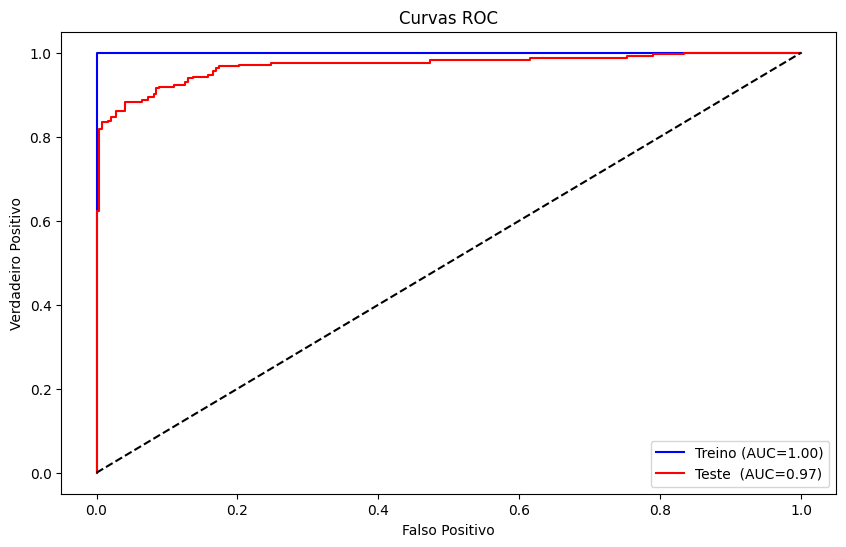

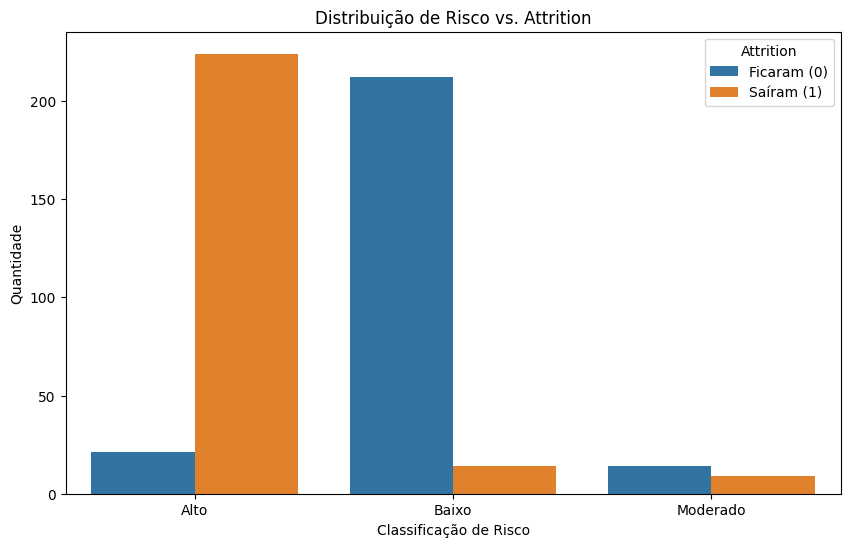

In [14]:
# ============================================================================
#       MODELAGEM 2: GRADIENT BOOSTING CLASSIFIER com GridSearchCV
# ============================================================================

gb_model = GradientBoostingClassifier(random_state=42)

param_grid = {
    'n_estimators': [100, 200],
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 4, 5]
}

grid_search = GridSearchCV(
    gb_model,
    param_grid,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1
)

grid_search.fit(X_train, y_train)
gb_model = grid_search.best_estimator_
print("Melhor Modelo (GridSearch):\n", gb_model)

_ = evaluate_classification_model(gb_model, X_train, y_train, X_test, y_test)

# classificação de risco - Teste
df_risco_gb = create_risk_df(gb_model, X_test, y_test,
                             low_threshold=0.10, 
                             medium_threshold=0.40)
plot_risk_distribution(df_risco_gb)


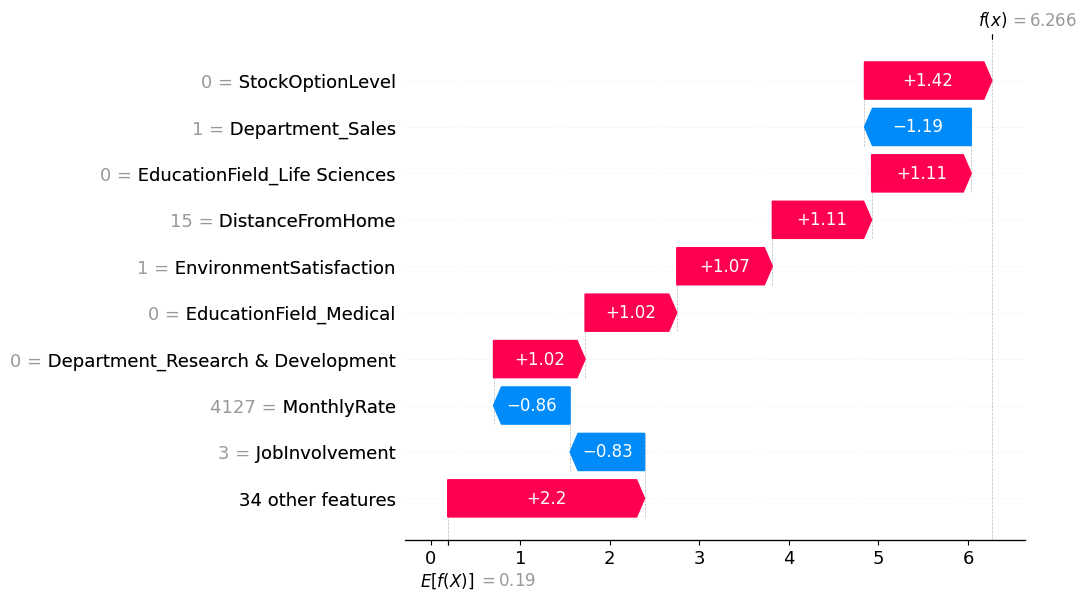

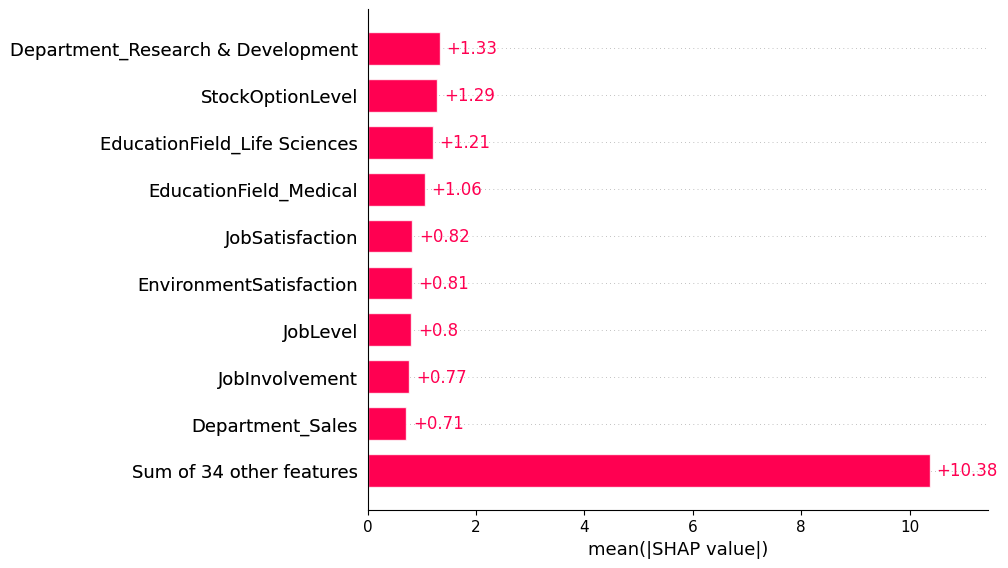

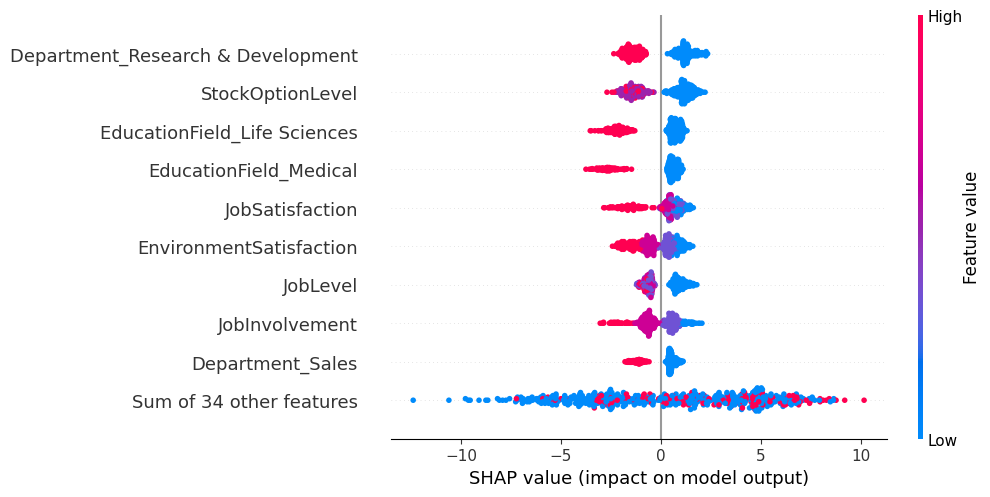

In [15]:
# ============================================================================
#            EXPLICANDO AS PREDIÇÕES USANDO SHAP
# ============================================================================
# Interpretabilidade do XGBoost
explainer = shap.Explainer(gb_model, X_train)
shap_values = explainer(X_test)

# Waterfall
shap.plots.waterfall(shap_values[0])  # índice 0 ou outro índice de teste

# Bar plot das principais features
shap.plots.bar(shap_values)

# Beeswarm
shap.plots.beeswarm(shap_values)

In [ ]:
# ============================================================================
#            EXPORTANDO O MODELO NO FORMATO PICKLE
# ============================================================================

# joblib.dump(rfc, "../04. ML Model//random_forest_model.pkl")